### Create Train and Test Datasets
---

This notebook loads a dataset from synthetic neural activity signals then splits it equal halves train and test datasets.
 
We then plot sequences from the two halves to see if they are organized correctly for next-timestep sequence-to-sequence prediction.

#### Libraries
---

In [1]:
# %load_ext cudf.pandas
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302, VALID_DATASETS, SYNTHETIC_DATASETS
from data._utils import create_combined_dataset, split_combined_dataset

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Create datasets
---

In [2]:
%%time
# Create a single combined dataset from the one of the 8 experimental datasets of your choice
experimental_dataset = "Leifer2023"
assert experimental_dataset in set(VALID_DATASETS) | set(SYNTHETIC_DATASETS), f"Invalid dataset: {experimental_dataset}"
datasets = dict(Leifer2023=1)  # a real worm neural dataset (1 worm)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = num_val_samples = num_samples = 2
reverse = use_residual = False
smooth_data = True
train_split_first = False
train_split_ratio = 0.5
seq_len = 500
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
    train_split_first,
    train_split_ratio,
)

CPU times: user 1.73 s, sys: 3.7 s, total: 5.44 s
Wall time: 10.6 s


#### Sample train and test sequences
---

In [3]:
%%time
# NOTE: The last train sample comes right before the first test sample.

# Get the sample from the train dataset
X_train, Y_train, mask_train, meta_train = train_dataset[-1]
time_train = meta_train["time_vec"]
print(
    f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
)

# Get the sample from the validation dataset
X_test, Y_test, mask_test, meta_test = val_dataset[0]
time_test = meta_test["time_vec"]
print(
    f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)


X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])


X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])

CPU times: user 91 µs, sys: 62 µs, total: 153 µs
Wall time: 156 µs


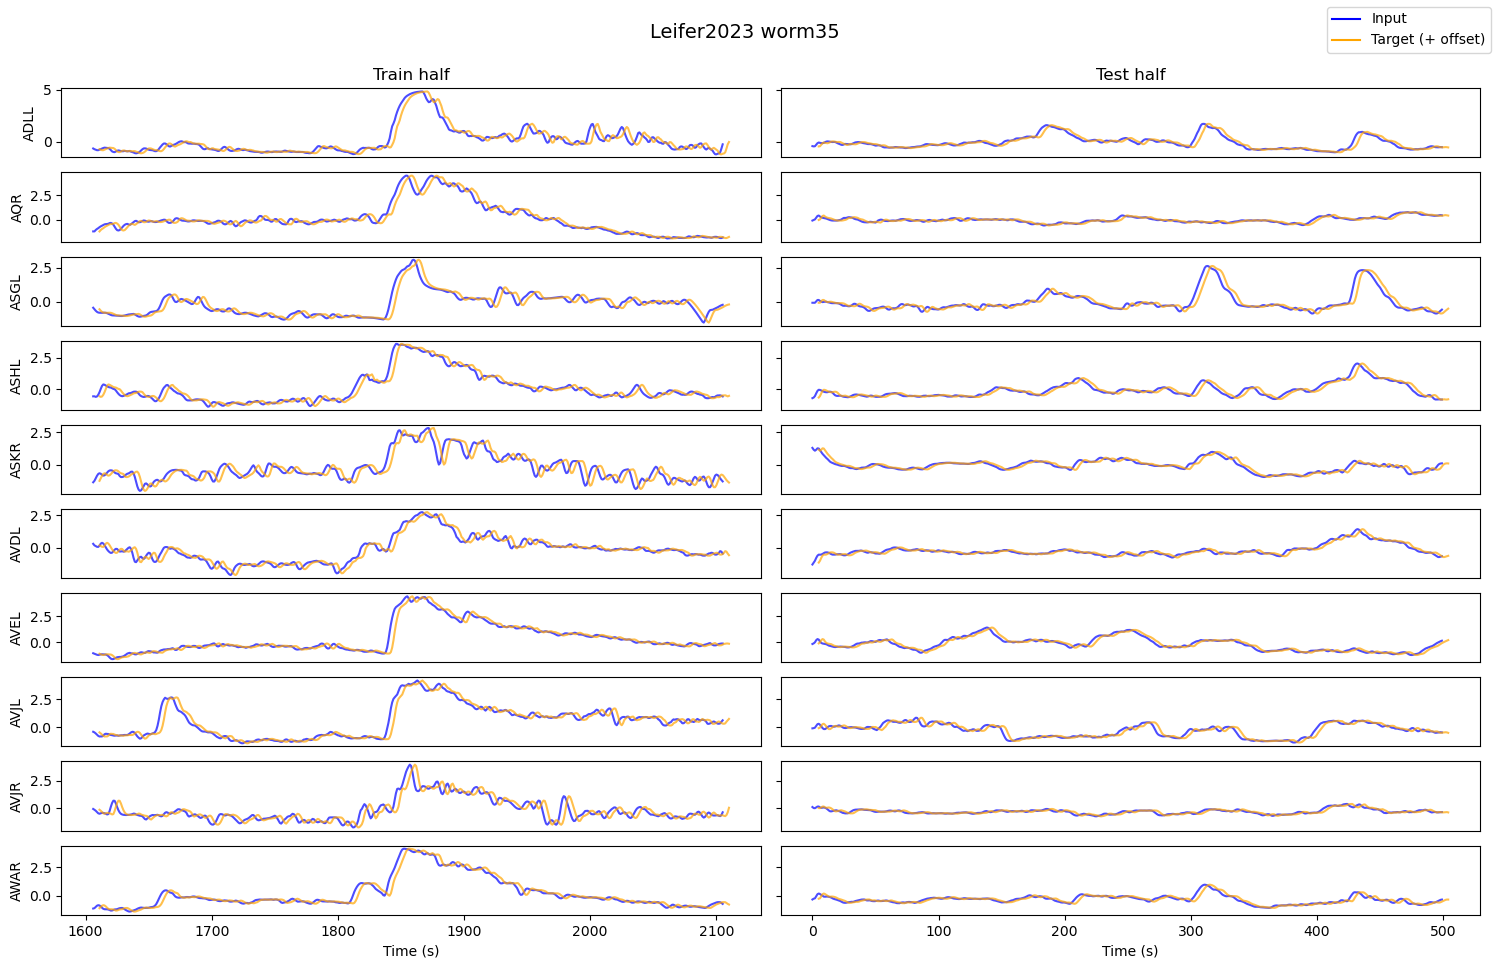

CPU times: user 2.62 s, sys: 123 ms, total: 2.74 s
Wall time: 2.7 s


In [4]:
%%time
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train = mask_train.sum().item()
num_neurons_test = mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.numpy()")
    X = eval(f"X_{phase}.numpy()")
    Y = eval(f"Y_{phase}.numpy()")
    mask = eval(f"mask_{phase}.numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 100

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette=["blue", "orange"],
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### Samples before and after training a model

In [5]:
%%time
from torch import no_grad
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils import VALID_DATASETS, DEVICE
from models._utils import LinearRegression
from train._utils import compute_loss_vectorized
from data._utils import create_combined_dataset, split_combined_dataset

# Create a single combined dataset from all the worms
datasets = dict(
    (dataset, "all") for dataset in VALID_DATASETS
)  # a real worm neural dataset (all worms)
combined_dataset, dataset_info = create_combined_dataset(
    datasets, num_named_neurons=None
)
num_worms = len(combined_dataset)

# Split the datsaet into train and validation halves
num_train_samples = 32
num_val_samples = 16
reverse = use_residual = False
smooth_data = True
train_split_first = False
train_split_ratio = 0.5
seq_len = 100
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
    train_split_first,
    train_split_ratio,
)

# Initialize the model and optimizer
model = LinearRegression(302).to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.001)

CPU times: user 6.74 s, sys: 5.97 s, total: 12.7 s
Wall time: 17.8 s


### Before training

In [6]:
%%time
# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

with no_grad():
    X_train, Y_train, mask_train, meta_train = next(iter(train_loader))
    time_train = meta_train["time_vec"]
    Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
    print(
        f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
    )

    X_test, Y_test, mask_test, meta_test = next(iter(val_loader))
    Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
    time_test = meta_test["time_vec"]
    print(
        f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)


X:torch.Size([1, 100, 302])
Y:torch.Size([1, 100, 302])
mask:torch.Size([1, 302])
time:torch.Size([1, 100])


X:torch.Size([1, 100, 302])
Y:torch.Size([1, 100, 302])
mask:torch.Size([1, 302])
time:torch.Size([1, 100])

CPU times: user 814 ms, sys: 1.57 s, total: 2.38 s
Wall time: 2.46 s


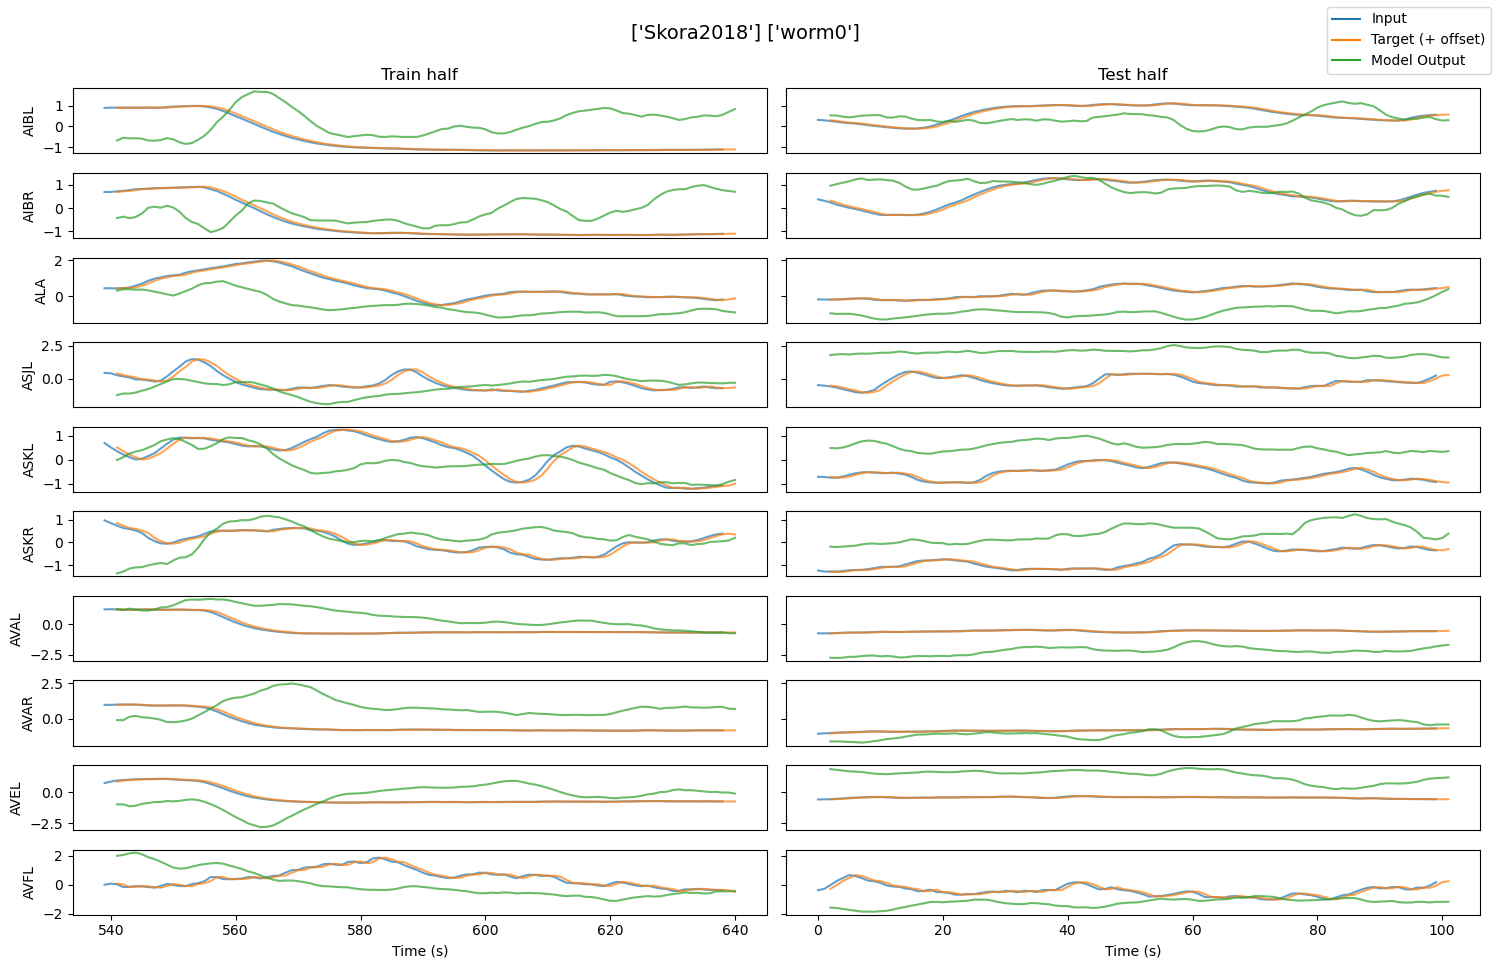

CPU times: user 3.06 s, sys: 166 ms, total: 3.23 s
Wall time: 3.29 s


In [7]:
%%time
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train, num_neurons_test = mask_train.sum().item(), mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()") # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()") # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()") # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### After training

In [8]:
%%time
# Create a training pipeline
for epoch in range(2):  # train for 2 epochs
    print(f"Epoch: {epoch+1}/{2}")
    # Training loop
    model.train()  # set model to training mode
    avg_train_loss = 0.0
    for batch in train_loader:
        X, Y, mask, meta = batch  # get input and target data
        optimizer.zero_grad()  # zero gradients
        Y_pred = model(X.to(DEVICE), mask.to(DEVICE))  # forward pass
        loss = compute_loss_vectorized(
            model.loss_fn(), Y_pred, Y.to(DEVICE), mask.to(DEVICE)
        )  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update model weights
        avg_train_loss += loss.item() / len(train_loader)
    print(f"\tTrain loss: {avg_train_loss}")

    # Validation loop
    model.eval()  # set model to evaluation mode
    with no_grad():
        avg_val_loss = 0.0
        for batch in val_loader:
            X, Y, mask, meta = batch
            Y_pred = model(X.to(DEVICE), mask.to(DEVICE))
            loss = compute_loss_vectorized(
                model.loss_fn(), Y_pred, Y.to(DEVICE), mask.to(DEVICE)
            )
            avg_val_loss += loss.item() / len(val_loader)
        print(f"\t\tVal loss: {avg_val_loss}")

Train loss: 0.24108115543773767
	Val loss: 0.29573023987894653
Train loss: 0.17204336406463092
	Val loss: 0.27269026906472255
CPU times: user 1min 28s, sys: 2.12 s, total: 1min 30s
Wall time: 1min 43s


In [9]:
%%time
# Get inputs and targets from dataloaders and outputs from model
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

with no_grad():
    X_train, Y_train, mask_train, meta_train = next(iter(train_loader))
    time_train = meta_train["time_vec"]
    Y_pred_train = model(X_train.to(DEVICE), mask_train.to(DEVICE))
    print(
        f"\nX:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}\n"
    )

    X_test, Y_test, mask_test, meta_test = next(iter(val_loader))
    Y_pred_test = model(X_test.to(DEVICE), mask_test.to(DEVICE))
    time_test = meta_test["time_vec"]
    print(
        f"\nX:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}\n"
)


X:torch.Size([1, 100, 302])
Y:torch.Size([1, 100, 302])
mask:torch.Size([1, 302])
time:torch.Size([1, 100])


X:torch.Size([1, 100, 302])
Y:torch.Size([1, 100, 302])
mask:torch.Size([1, 302])
time:torch.Size([1, 100])

CPU times: user 5.35 ms, sys: 0 ns, total: 5.35 ms
Wall time: 10.1 ms


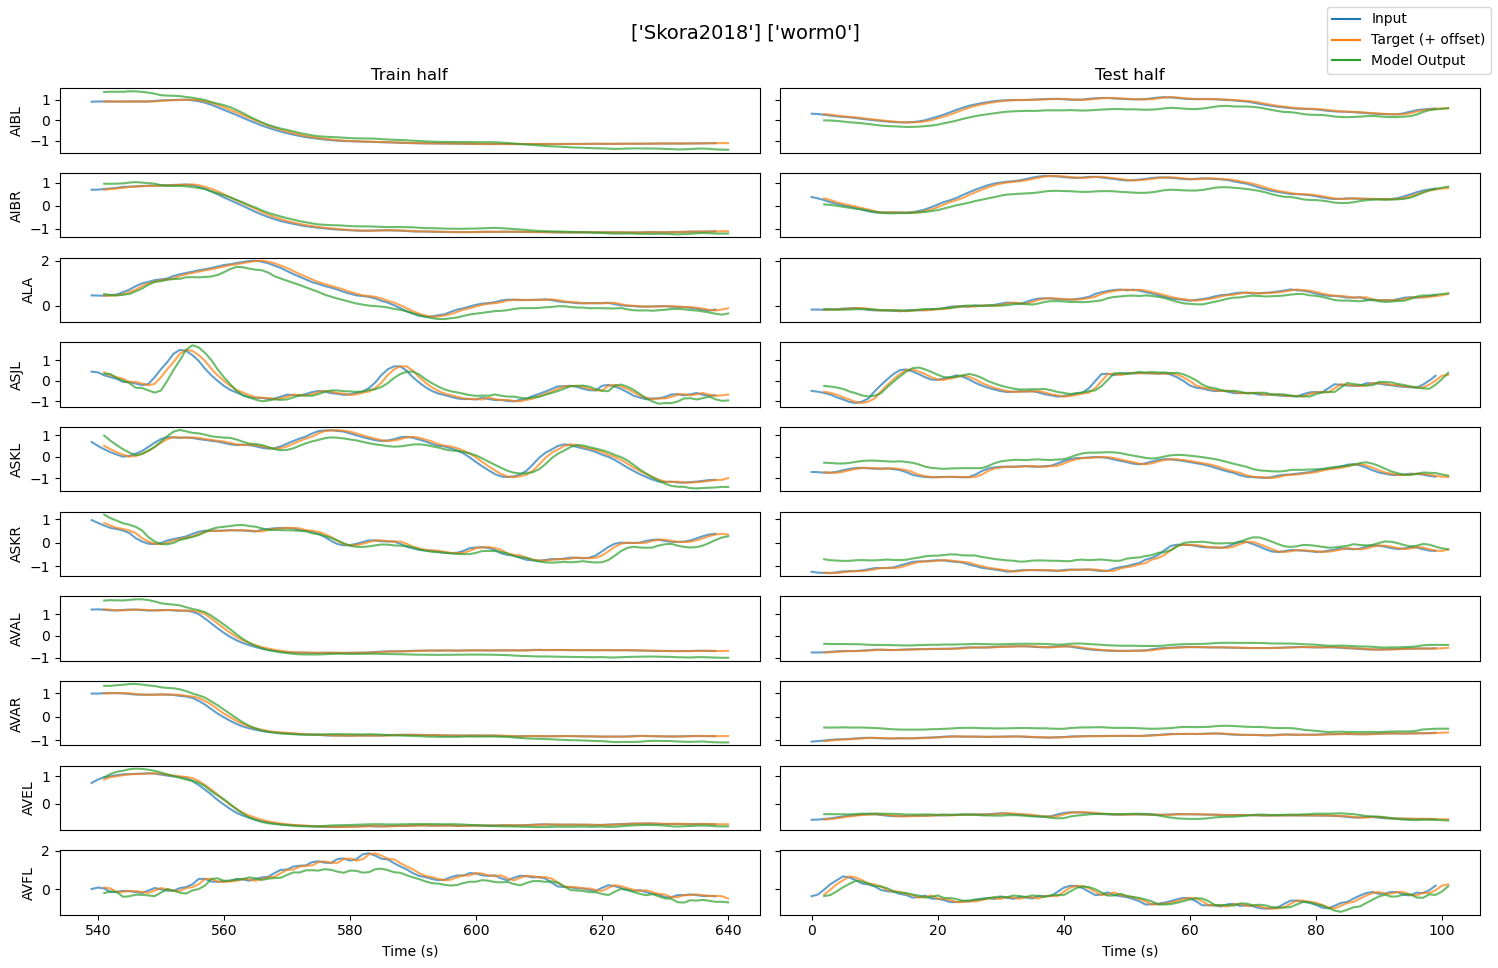

CPU times: user 2.72 s, sys: 133 ms, total: 2.85 s
Wall time: 2.96 s


In [10]:
%%time
# Set up the matplotlib figure for two columns of subplots
max_neurons_to_plot = 10
num_neurons_train, num_neurons_test = mask_train.sum().item(), mask_test.sum().item()
num_neurons = min(max_neurons_to_plot, num_neurons_train, num_neurons_test)
fig, axes = plt.subplots(num_neurons, 2, figsize=(15, 10), sharey="row")

# Plot data for each half
for col, phase in enumerate(["train", "test"]):
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.squeeze().cpu().numpy()")
    X = eval(f"X_{phase}.detach().squeeze().cpu().numpy()") # input
    Y = eval(f"Y_{phase}.squeeze().cpu().numpy()") # target
    Y_pred = eval(f"Y_pred_{phase}.detach().squeeze().cpu().numpy()") # output
    mask = eval(f"mask_{phase}.detach().squeeze().cpu().numpy()")
    worm_dataset = eval(f"meta_{phase}['worm_dataset']")
    wormID = eval(f"meta_{phase}['wormID']")

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 50

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0][:num_neurons]

    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target (+ offset)",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

        # Collect output data with time offset
        output_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y_pred[:, neuron_idx],
                "Type": "Model Output",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(output_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Plot the lines
    for i, neuron_label in enumerate(neurons_to_plot):
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=axes[i, col],
            palette="tab10",
            alpha=0.7,
            errorbar=None,
        )
        axes[i, col].set_ylabel(NEURONS_302[neuron_label])
        axes[i, col].get_legend().remove()

        # Set the x-axis label to empty
        axes[i, col].set_xlabel("")

        # Hide x-axis labels and ticks for all but the last row
        if i < num_neurons - 1:
            axes[i, col].set_xticklabels([])
            axes[i, col].set_xticks([])
        else:
            axes[i, col].set_xlabel("Time (s)")

        # Set title only for the first row of each column
        if i == 0:
            axes[i, col].set_title(f"{phase.capitalize()} half")
        else:
            axes[i, col].set_title("")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display name of dataset and worm as suptitle
fig.suptitle(f"{worm_dataset} {wormID}", fontsize=14)

# Display the legend outside the rightmost plot
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.show()

### TODO: helper function for plotting 

In [11]:
# def plot_train_test_sample(train_sample, test_sample, model=None):
#     """
#     Plots a single sample from the train and test datasets.
#     Args:
#         train_sample (tuple): a single sample from the train dataset
#         test_sample (tuple): a single sample from the test dataset
#         model (nn.Module): a PyTorch model to use for prediction
#     """
#     # Check shapes
#     if train_sample.ndim == 3:  # could have been input as a batch
#         assert train_sample.shape[0] == 1  # batch size must be 1
#         train_sample = train_sample.squeeze(0)
#     if test_sample.ndim == 3:
#         assert test_sample.shape[0] == 1
#         test_sample = test_sample.squeeze(0)
#     assert (
#         train_sample.ndim == 2 and test_sample.ndim == 2
#     ), "Invalid sample shape. Please use a single train and test sample of shape (seq_len, num_neurons)."
#     X_train, Y_train, mask_train, meta_train = train_sample
#     X_test, Y_test, mask_test, meta_test = test_sample

#     return None